## Day 3: Cells in Silicon

Welcome to Day 3! Today, we start with our discussion with the Hodgkin Huxley Neurons and how we can simulate them in python using Tensorflow and Numerical Integration.

### What is the Hodgkin Huxley Neuron Model?

... Insert Text Here ...

#### Dynamical State Equations

... Insert Text Here ...

#### Recalling the Generalized TensorFlow Integrator
On day 2, we had created a RK4 based numerical integrator. We recall the implementation of the Integrator.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline


def tf_check_type(t, y0): # Ensure Input is Correct
    if not (y0.dtype.is_floating and t.dtype.is_floating):
        raise TypeError('Error in Datatype')

def tf_check_increasing(t): # Ensure Time is Monotonically Increasing
    assert_op = tf.Assert(tf.reduce_all(t[1:]>t[:-1]),["Time must be monotonic"])
    return tf.control_dependencies([assert_op])

class _Tf_Integrator():
    
    def integrate(self, func, y0, t): 
        time_delta_grid = t[1:] - t[:-1]
        scan_func = self._make_scan_func(func)
        y = tf.scan(scan_func, (t[:-1], time_delta_grid),y0)
        return tf.concat([[y0], y], axis=0)
    
    def _make_scan_func(self, func): # stepper function
        def scan_func(y, t_dt): 
            t, dt = t_dt
            dy = self._step_func(func,t,dt,y) # Make code more modular.
            dy = tf.cast(dy, dtype=y.dtype) # Failsafe
            return y + dy
        return scan_func
    
    def _step_func(self, func, t, dt, y):
        k1 = func(y, t)
        half_step = t + dt / 2
        dt_cast = tf.cast(dt, y.dtype) # Failsafe

        k2 = func(y + dt_cast * k1 / 2, half_step)
        k3 = func(y + dt_cast * k2 / 2, half_step)
        k4 = func(y + dt_cast * k3, t + dt)
        return tf.add_n([k1, 2 * k2, 2 * k3, k4]) * (dt_cast / 6)
    

def odeint(func, y0, t):
    t = tf.convert_to_tensor(t, preferred_dtype=tf.float64, name='t')
    y0 = tf.convert_to_tensor(y0, name='y0')
    tf_check_type(y0,t)
    with tf_check_increasing(t):
        return _Tf_Integrator().integrate(func,y0,t)

#### Implementing the Dynamical Function for an Hodkin Huxley Neuron

Recall, a simple Hodgkin Huxley Neuron has a 4 main dynamical variables:

$V = Membrane\ Potential$  
$m = Sodium\ Activation\ Gating\ Variable$  
$h = Sodium\ Inactivation\ Gating\ Variable$  
$n = Potassium\ Channel\ Gating\ Variable$

And the dynamics are given by:

$$C_m\frac{dV}{dt} = I_{injected} - I_{Na} - I_K - I_L$$

$$\frac{dm}{dt} = - \frac{1}{\tau_m}(m-m_0)$$

$$\frac{dh}{dt} = - \frac{1}{\tau_h}(h-h_0)$$

$$\frac{dn}{dt} = - \frac{1}{\tau_n}(n-n_0)$$

where the values of $\tau_m$, $\tau_h$, $\tau_n$, $m_0$, $h_0$, $n_0$ are given from the equations mentioned earlier.

##### Step 1: Defining Parameters of the Neuron 

In [7]:
C_m = 1      # Membrane Capacitance
g_K = 10
E_K = -95

g_Na = 100
E_Na = 50 

g_L = 0.15
E_L = -55

##### Step 2: Defining functions that calculate $\tau_m$, $\tau_h$, $\tau_n$, $m_0$, $h_0$, $n_0$ 


In [8]:
def K_prop(V):
    T = 22
    phi = 3.0**((T-36.0)/10)
    V_ = V-(-50)
    
    alpha_n = 0.02*(15.0 - V_)/(tf.exp((15.0 - V_)/5.0) - 1.0)
    beta_n = 0.5*tf.exp((10.0 - V_)/40.0)
    
    t_n = 1.0/((alpha_n+beta_n)*phi)
    n_inf = alpha_n/(alpha_n+beta_n)
    
    return n_inf, t_n


def Na_prop(V):
    T = 22
    phi = 3.0**((T-36)/10)
    V_ = V-(-50)
    
    alpha_m = 0.32*(13.0 - V_)/(tf.exp((13.0 - V_)/4.0) - 1.0)
    beta_m = 0.28*(V_ - 40.0)/(tf.exp((V_ - 40.0)/5.0) - 1.0)
    
    alpha_h = 0.128*tf.exp((17.0 - V_)/18.0)
    beta_h = 4.0/(tf.exp((40.0 - V_)/5.0) + 1.0)
    
    t_m = 1.0/((alpha_m+beta_m)*phi)
    t_h = 1.0/((alpha_h+beta_h)*phi)
    
    m_inf = alpha_m/(alpha_m+beta_m)
    h_inf = alpha_h/(alpha_h+beta_h)
    
    return m_inf, t_m, h_inf, t_h

##### Step 3: Defining function that calculate Neuronal currents

In [9]:
def I_K(V, n):
    return g_K  * n**4 * (V - E_K)

def I_Na(V, m, h):
    return g_Na * m**3 * h * (V - E_Na)

def I_L(V):
    return g_L * (V - E_L)

##### Step 4: Define the function dA/dt where A is the State Vector

In [10]:
def dAdt(X, t):
    V = X[0:1]
    m = X[1:2]
    h = X[2:3]
    n = X[3:]
    
    dVdt = (5 - I_Na(V, m, h) - I_K(V, n) - I_L(V)) / C_m
    
    m0,tm,h0,th = Na_prop(V)
    n0,tn = K_prop(V)

    dmdt = - (1.0/tm)*(m-m0)
    dhdt = - (1.0/th)*(h-h0)
    dndt = - (1.0/tn)*(n-n0)

    out = tf.concat([dVdt,dmdt,dhdt,dndt],0)
    return out

##### Step 5: Define Initial Condition and Integrate

In [11]:
y0 = tf.constant([-71,0,0,0], dtype=tf.float64)

epsilon = 0.01
t = np.arange(0,200,epsilon)

state = odeint(dAdt,y0,t)

with tf.Session() as sess:
    state = sess.run(state)

##### Step 6: Plot Output

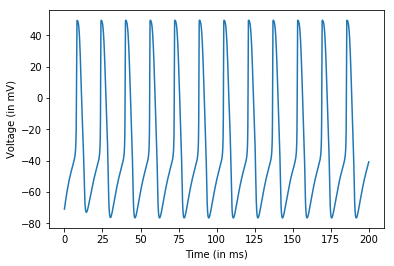

In [12]:
plt.plot(t,state.T[0,:])

plt.xlabel("Time (in ms)")
plt.ylabel("Voltage (in mV)")

plt.show()

#### Simulating Multiple Independent HH Neurons at the Same Time

Although, simulating a Single Hodgkin-Huxley Neuron is possible in TensorFlow, the real ability of tensorflow can be seen only when a large number of simultaneous diffential equations are to be solved at the the same time. Let's try to simulate 20 independent HH neurons with different input currents and characterise the firing rates. 

##### Methods of Parallelization
TensorFlow has the intrinsic ability to speed up any and all Tensor computations using available multi-cores, and GPU/TPU setups. There are two major parts of the code where TensorFlow can help us really speed up the computation:
1. **RK4 Steps:** Since the TensorFlow implementation of the Integrator utilizes Tensor calculations, TensorFlow will automatically speed it up.
2. **Functional Evaluations:** Looking at Dynamical Equations that describe the neuronal dynamics, its easy to notice that all simple HH Neurons share the same or atleast similar dynamical equations but will vary only in the values of parameters. We can exploit this to speed up the computations.


Say $\vec{X}=[x_1,x_2...x_m]$ is the state vector of a single neuron and its dynamics are defined by parameters $\vec{p}= [p_1,p_2...p_l]$ (l in number) equations of the form: $$\frac{d\vec{X}}{dt} = [f_1(\vec{X},\vec{p}),f_2(\vec{X},\vec{p})...f_m(\vec{X},\vec{p})]$$ We have to somehow convert these to a form in which all evaluations are done as vector calculations and NOT scalar calculations.

So, what we need for a system of n neurons is to have a method to evaluate the updation of $\mathbf{X}=[\vec{X_1},\vec{X_2}...\vec{X_n}]$ where $\vec{X_i}$ is the state vector of the $i$th neuron. Now there is a simple trick that allows us to maximize the parallel processing. Each neuron represented by $\vec{X_i}$ has a distinct set of parameters $\vec{p_i}=[p_{i1},p_{i2}...p_{il}]$ and differential equations $$\frac{d\vec{X_i}}{dt} = [f_1(\vec{X_i},\vec{p_i}),f_2(\vec{X_i},\vec{p_i})...f_m(\vec{X_i},\vec{p_i})] = \vec{f}(\vec{X_i},\vec{p_i})$$

Now, despite the parameters being different, the functional forms of the updation is similar for the same state variable for different neurons. Thus, the trick is to reorganize $\mathbf{X}=[\vec{X_1},\vec{X_2}...\vec{X_n}]=[(x_{11}...x_{1m}),(x_{21}...x_{2m})...(x_{n1}...x_{nm})]$ as $$\mathbf{X'}=[(x_{11},x_{21}...x_{n1}),(x_{12},x_{22}...x_{n2})...(x_{1m},x_{2m}...x_{nm})]=[\vec{x_1},\vec{x_2}...\vec{x_m}]$$

Now that we know the trick, what is the benefit? Earlier, each state variable (say variable i of neuron j) had a DE of the form: $$\frac{dx_{ji}}{dt}=f_i(p_{jk}...,x_{jq}...)$$. This is now easily parallelizable using a vector computation of a form: $$\frac{d\vec{x_{i}}}{dt}=f_i(\vec{P_i}...\vec{x_q}...)$$ where $\mathbf{P}=[\vec{P_1},\vec{P_2}...\vec{P_l}] = [(p_{11},p_{21}...p_{n1}),(p_{12},p_{22}...p_{n2})...(p_{1l},p_{2l}...x_{nm})]=[\vec{x_1},\vec{x_2}...\vec{x_m}]$

Thus we can do the calculations as:
$$\frac{d\mathbf{X'}}{dt}= [\frac{d\vec{x_1}}{dt},\frac{d\vec{x_2}}{dt}...\frac{d\vec{x_n}}{dt}]$$

In [13]:
n_n = 20 # number of simultaneous neurons to simulate

# parameters will now become n_n-vectors

C_m = [1.0]*n_n
g_K = [10.0]*n_n
E_K = [-95.0]*n_n

g_Na = [100]*n_n
E_Na = [50]*n_n 

g_L = [0.15]*n_n
E_L = [-55.0]*n_n


def K_prop(V):
    T = 22
    phi = 3.0**((T-36.0)/10)
    V_ = V-(-50)
    
    alpha_n = 0.02*(15.0 - V_)/(tf.exp((15.0 - V_)/5.0) - 1.0)
    beta_n = 0.5*tf.exp((10.0 - V_)/40.0)
    
    t_n = 1.0/((alpha_n+beta_n)*phi)
    n_inf = alpha_n/(alpha_n+beta_n)
    
    return n_inf, t_n


def Na_prop(V):
    T = 22
    phi = 3.0**((T-36)/10)
    V_ = V-(-50)
    
    alpha_m = 0.32*(13.0 - V_)/(tf.exp((13.0 - V_)/4.0) - 1.0)
    beta_m = 0.28*(V_ - 40.0)/(tf.exp((V_ - 40.0)/5.0) - 1.0)
    
    alpha_h = 0.128*tf.exp((17.0 - V_)/18.0)
    beta_h = 4.0/(tf.exp((40.0 - V_)/5.0) + 1.0)
    
    t_m = 1.0/((alpha_m+beta_m)*phi)
    t_h = 1.0/((alpha_h+beta_h)*phi)
    
    m_inf = alpha_m/(alpha_m+beta_m)
    h_inf = alpha_h/(alpha_h+beta_h)
    
    return m_inf, t_m, h_inf, t_h

def I_K(V, n):
    return g_K  * n**4 * (V - E_K)

def I_Na(V, m, h):
    return g_Na * m**3 * h * (V - E_Na)

def I_L(V):
    return g_L * (V - E_L)

def dAdt(X, t):
    V = X[:1*n_n]       # First n_n values are Membrane Voltage
    m = X[1*n_n:2*n_n]  # Next n_n values are Sodium Activation Gating Variables
    h = X[2*n_n:3*n_n]  # Next n_n values are Sodium Inactivation Gating Variables
    n = X[3*n_n:]       # Last n_n values are Potassium Gating Variables
    
    dVdt = (np.linspace(0,10,n_n) - I_Na(V, m, h) - I_K(V, n) -I_L(V)) / C_m 
    # Input current is linearly varied between 0 and 10
    
    m0,tm,h0,th = Na_prop(V)
    n0,tn = K_prop(V)

    dmdt = - (1.0/tm)*(m-m0)
    dhdt = - (1.0/th)*(h-h0)
    dndt = - (1.0/tn)*(n-n0)

    out = tf.concat([dVdt,dmdt,dhdt,dndt],0)
    return out


y0 = tf.constant([-71]*n_n+[0,0,0]*n_n, dtype=tf.float64)

epsilon = 0.01
t = np.arange(0,200,epsilon)

state = odeint(dAdt,y0,t)

with tf.Session() as sess:
    state = sess.run(state)

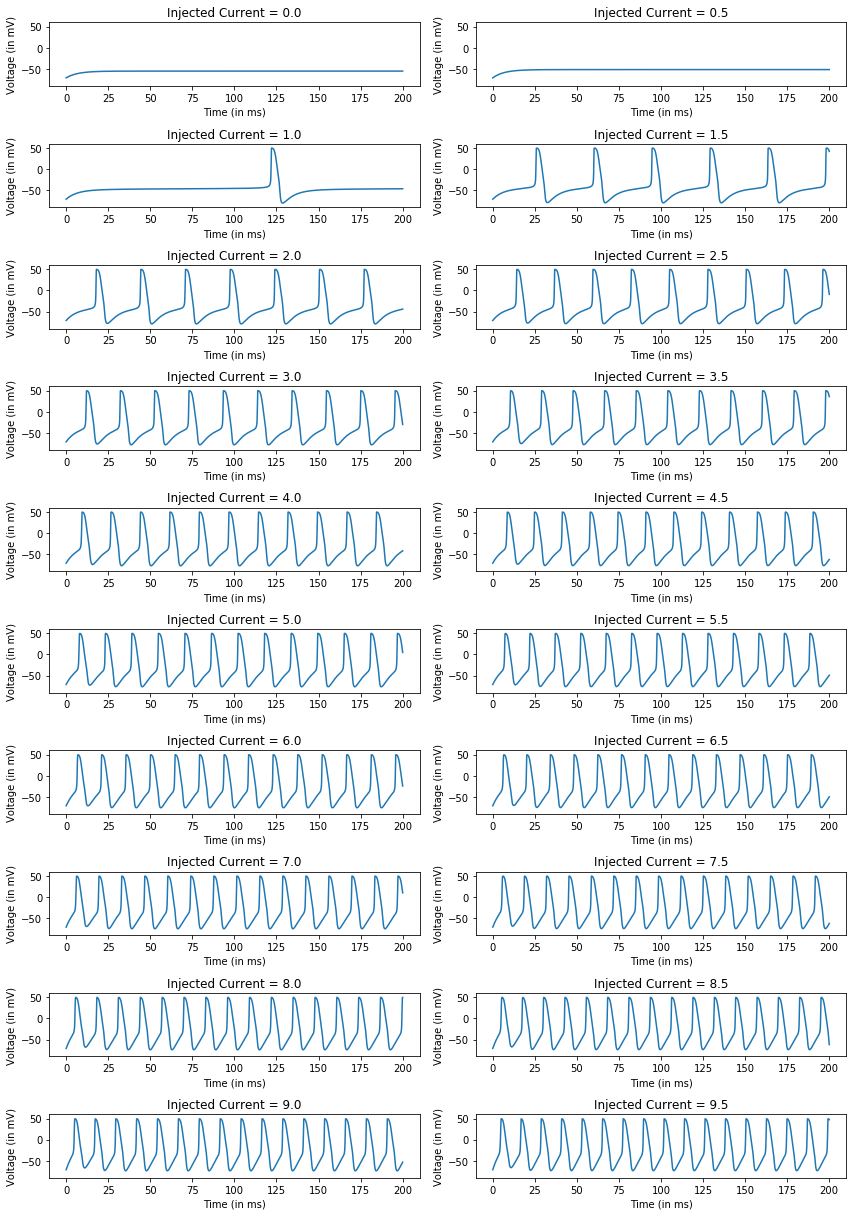

In [76]:
plt.figure(figsize=(12,17))
for i in range(20):
    plt.subplot(10,2,i+1)
    plt.plot(t,state[:,i])
    plt.title("Injected Current = {:0.1f}".format(i/2))
    plt.ylim([-90,60])
    plt.xlabel("Time (in ms)")
    plt.ylabel("Voltage (in mV)")

plt.tight_layout()
plt.show()

#### Quantifying the Firing Rates against Input Current

One way to quantify the firing rate is to perform a fourier analysis and find peak frequency, but an easier way to find the rate is to see how many times it crosses a threshold say 0 mV in a given time, here it is for 200ms = 0.2s, and find the rate.

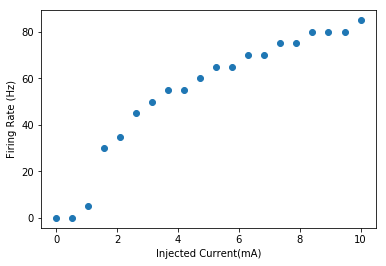

In [77]:
plt.plot(np.linspace(0,10,20),np.bitwise_and(state[:-1,:20]<0,state[1:,:20]>0).sum(axis=0)/0.2,"o")
plt.xlabel("Injected Current(mA)")
plt.ylabel("Firing Rate (Hz)")